# Segmentação
1. Segmentação baseada em histograma
    
    1.1 Método de Otsu
    
    1.2 Renyi Entropy
    
    1.3 Limiarização adaptativa

2. Segmentação com base na região
    
    2.1 Segmentação por inuindação (Watershed Segmentation)

3. Segmentação baseada em contorno
    
    3.1 Segmentação Chan-Vese

4. Algoritmo de Segmentação para Várias Modalidades
    
    4.1 Segmentação de Imagem de Tomografia Computadorizada
    
    4.2 Segmentação de imagem de ressonância magnética
    
    4.3 Segmentação de Imagens de Microscópio Óptico e Eletrônico

In [1]:
import cv2 as cv
print("OpenCV: ", cv.__version__)
import numpy as np
print("numpy: ", np.__version__)
import matplotlib.pyplot as plt
plt.style.use('classic')
#%matplotlib
#%matplotlib notebook
#%matplotlib inline
%matplotlib widget
from skimage.filters.thresholding import threshold_otsu
from skimage.segmentation import chan_vese
import skimage.exposure as imexp
from PIL import Image
from scipy.ndimage import label

OpenCV:  4.7.0
numpy:  1.24.2


(1086, 663, 3)


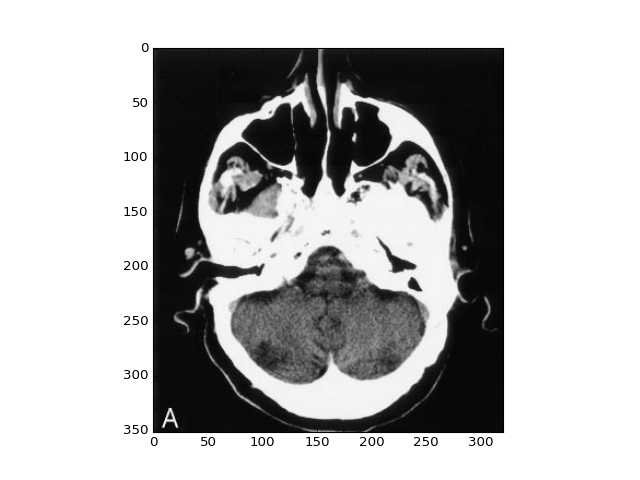

In [2]:
img = cv.imread('Imagens/image1.png')
print(img.shape)
lin, col = img.shape[:2]
img = img[:lin//3 - 10, :col//2 - 10,:]
fig = plt.figure()
ax = plt.axes()
ax.imshow(img, 'gray')

In [3]:
# Converting the image to grayscale.
imgG = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [4]:
#Segmentação baseada em histograma
    
    

(-0.5, 320.5, 351.5, -0.5)

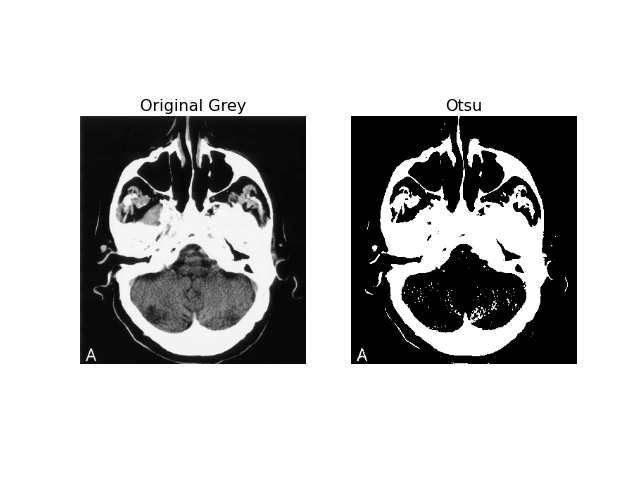

In [5]:
#Método de Otsu
thresh = threshold_otsu(imgG)
# Pixels with intensity greater than the
# "threshold" are kept.
imgOtsu = 255*(imgG > thresh)    

fig, ax = plt.subplots(1,2)
ax[0].imshow(imgG, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original Grey')
ax[0].axis('off')
ax[1].imshow(imgOtsu, cmap='gray')
ax[1].set_title('Otsu')
ax[1].axis('off')


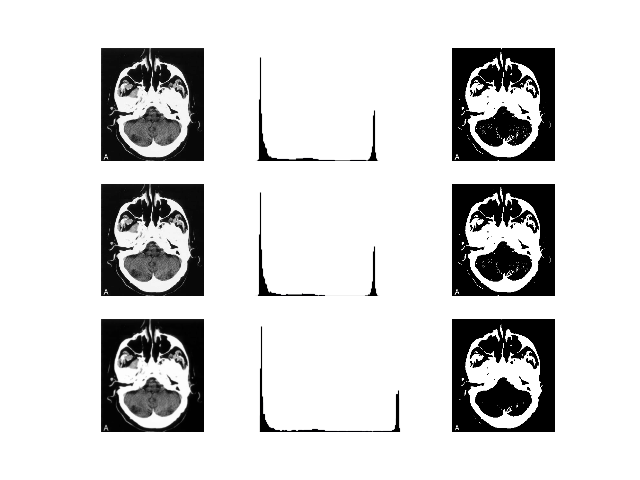

In [6]:
# global thresholding
ret1,th1 = cv.threshold(imgG,127,255,cv.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv.threshold(imgG,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(imgG,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [imgG, 0, th1,
          imgG, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
fig, ax = plt.subplots(3,3)
for i in range(3):
    ax[i, 0].imshow(images[i*3],'gray')
    #ax[i, 0].title(titles[i*3]) 
    ax[i, 0].axis('off')
    
    ax[i, 1].hist(images[i*3].ravel(),256)
    #ax[i, 1].title(titles[i*3+1])
    ax[i, 1].axis('off')
    
    ax[i, 2].imshow(images[i*3+2],'gray')
    #ax[i, 2].title(titles[i*3+2]) 
    ax[i, 2].axis('off')

The renyi threshold is:  8


(-0.5, 320.5, 351.5, -0.5)

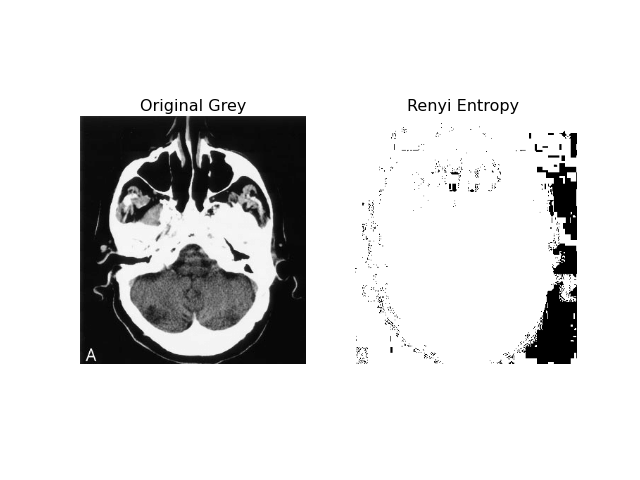

In [7]:
#Renyi Entropy
# Defining function
def renyi_seg_fn(im, alpha):
    hist, _ = imexp.histogram(im)
    # Convert all values to float
    hist_float = np.array([float(i) for i in hist])
    # compute the pdf
    pdf = hist_float/np.sum(hist_float)
    # compute the cdf
    cumsum_pdf = np.cumsum(pdf)
    s, e = im.min(), im.max()
    scalar = 1.0/(1.0-alpha)
    # A very small value to prevent error due to log(0).
    eps = np.spacing(1)
    
    rr = e-s
    # The inner parentheses is needed because
    # the parameters are tuple.
    h1 = np.zeros((rr, 1))
    h2 = np.zeros((rr, 1))
    # The following loop computes h1 and h2
    # values used to compute the entropy.
    for ii in range(1, rr):
        iidash = ii+s
        temp0 = pdf[0:iidash]/(cumsum_pdf[iidash])
        temp1 = np.power(temp0, alpha)
        h1[ii] = np.log(np.sum(temp1)+eps)
        temp0 = pdf[iidash+1:e]/(1.0-cumsum_pdf[iidash])
        temp2 = np.power(temp0, alpha)
        h2[ii] = np.log(np.sum(temp2)+eps)
    T = h1+h2
    # Entropy value is calculated
    T = T*scalar
    T = T.reshape((rr, 1))[:-2]
    # location where the maximum entropy
    # occurs is the threshold for the renyi entropy
    thresh = T.argmax(axis=0)
    return thresh

# Main program
# Computing the threshold by calling the function.
thresh = renyi_seg_fn(imgG, 3)
print('The renyi threshold is: ', thresh[0])
imgRE = 255*(imgG > thresh)

fig, ax = plt.subplots(1,2)
ax[0].imshow(imgG, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original Grey')
ax[0].axis('off')
ax[1].imshow(imgRE, cmap='gray')
ax[1].set_title('Renyi Entropy')
ax[1].axis('off')

(-0.5, 320.5, 351.5, -0.5)

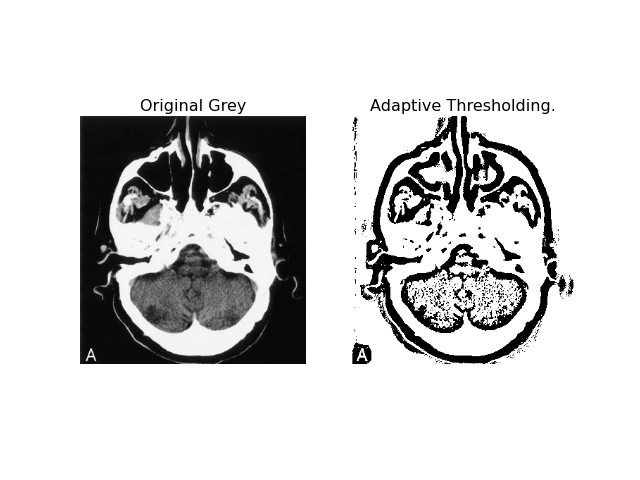

In [8]:
#Limiarização adaptativa
# Performing adaptive thresholding.
imgAT = cv.adaptiveThreshold(imgG,imgG.max(), cv.ADAPTIVE_THRESH_MEAN_C, 
                             cv.THRESH_BINARY,21,10)

fig, ax = plt.subplots(1,2)
ax[0].imshow(imgG, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original Grey')
ax[0].axis('off')
ax[1].imshow(imgAT, cmap='gray')
ax[1].set_title('Adaptive Thresholding.')
ax[1].axis('off')

In [9]:
#Segmentação com base na região


(-0.5, 320.5, 351.5, -0.5)

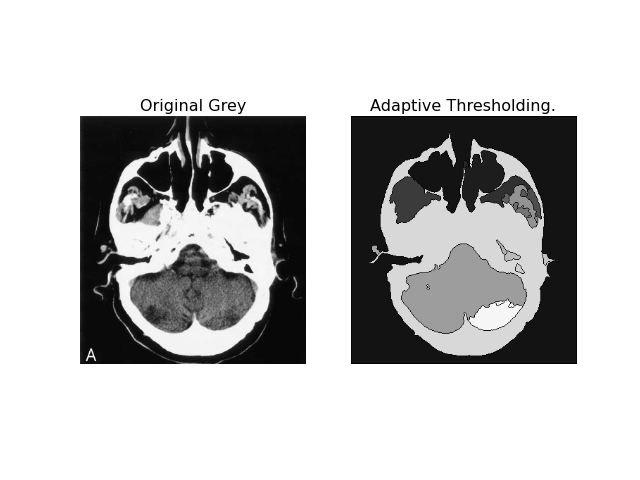

In [10]:
#Segmentação por inuindação (Watershed Segmentation)
# Thresholding the image to obtain cell pixels.
thresh,imgOut = cv.threshold(imgG, 0, 255,
            cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
# Since Otsu's method has over segmented the image
# erosion operation is performed.
imgOut = cv.erode(imgOut, None,iterations = 2)
# Distance transform is performed
dist_trans = cv.distanceTransform(imgOut, 2, 3)
# Thresholding the distance transform image to obtain
# pixels that are foreground.
thresh, dt = cv.threshold(dist_trans, 1,
             255, cv.THRESH_BINARY)
# Performing labeling.
labelled, ncc = label(dt)
# Performing watershed.
cv.watershed(img, labelled)

fig, ax = plt.subplots(1,2)
ax[0].imshow(imgG, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original Grey')
ax[0].axis('off')
ax[1].imshow(labelled, cmap='gray')
ax[1].set_title('Adaptive Thresholding.')
ax[1].axis('off')

In [11]:
#Segmentação baseada em contorno


(-0.5, 320.5, 351.5, -0.5)

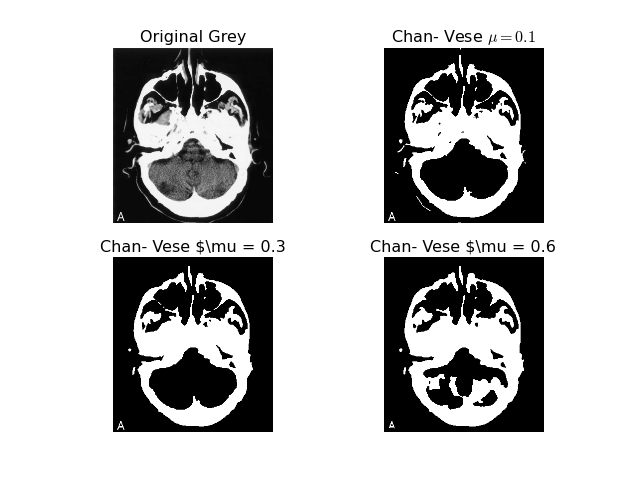

In [12]:
#Segmentação Chan-Vese
cv1 = chan_vese(imgG, mu=0.1)
cv2 = chan_vese(imgG, mu=0.3)
cv3 = chan_vese(imgG, mu=0.6)

fig, ax = plt.subplots(2,2)
ax[0, 0].imshow(imgG, cmap='gray')
ax[0, 0].set_title('Original Grey')
ax[0, 0].axis('off')
ax[0, 1].imshow(cv1, cmap='gray')
ax[0, 1].set_title('Chan- Vese $\mu = 0.1$')
ax[0, 1].axis('off')
ax[1, 0].imshow(cv2, cmap='gray')
ax[1, 0].set_title('Chan- Vese $\mu = 0.3')
ax[1, 0].axis('off')
ax[1, 1].imshow(cv3, cmap='gray')
ax[1, 1].set_title('Chan- Vese $\mu = 0.6')
ax[1, 1].axis('off')


In [13]:
#Algoritmo de Segmentação para Várias Modalidades


In [14]:
#Segmentação de Imagem de Tomografia Computadorizada


In [15]:
#Segmentação de imagem de ressonância magnética


In [16]:
#Segmentação de Imagens de Microscópio Óptico e Eletrônico